In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [81]:
num_epochs = 100

batch_size = 128

In [83]:
train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download=True)
test_dataset =  torchvision.datasets.CIFAR10(root= './data', train = False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [86]:
img, label = train_dataset[0]
img, label

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

Text(0.5, 1.0, 'frog')

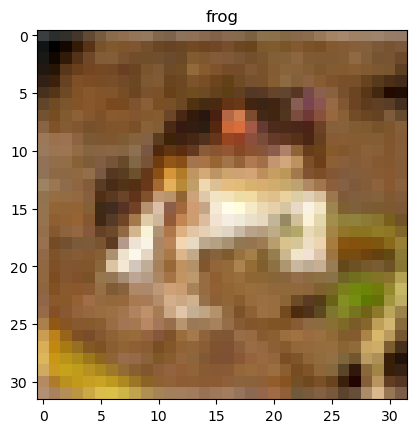

In [89]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}")

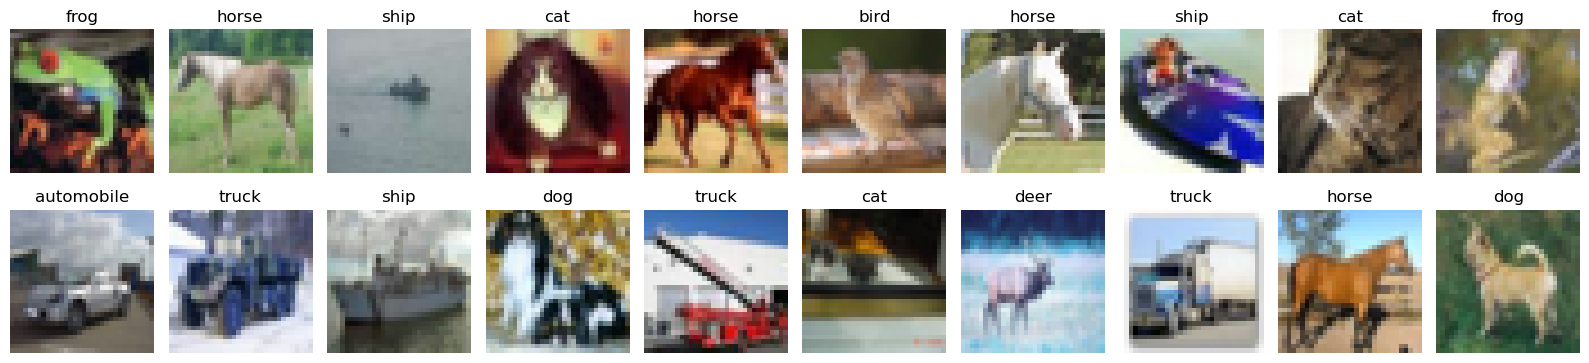

In [91]:
import torch
torch.manual_seed(42)     # Search on the internet why '42' is special or
                          # even '42 * 2' = 84

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [93]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
cifar_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,])

In [95]:
train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download=False, transform = cifar_transforms)
test_dataset =  torchvision.datasets.CIFAR10(root= './data', train = False, download=False, transform = cifar_transforms)

In [96]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset = train_dataset, lengths = [train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(45000, 5000, 10000)

In [99]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset =train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset= test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True)

In [101]:
import math
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG,self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    layers = []
    in_channels =3
    for out_channels in cfg:
        if out_channels == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2, stride =2)]
        else:
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding =1)
            layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = out_channels
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

def vgg16():
    return VGG(make_layers(cfg))

In [103]:
model = vgg16()

In [105]:
from torchmetrics import Accuracy
model = vgg16()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9, weight_decay = 5e-4)
accuracy = Accuracy(task='multiclass', num_classes=10)

In [107]:
from tqdm.notebook import tqdm
# torch.cuda.empty_cache()
# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model = model.to(device)

for epoch in tqdm(range(num_epochs)):
    # torch.cuda.empty_cache()
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        model.train()
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")
    

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  2.08643| Train acc:  0.17829| Val loss:  1.86173| Val acc:  0.25352
Epoch: 1| Train loss:  1.80995| Train acc:  0.27802| Val loss:  1.73856| Val acc:  0.30820
Epoch: 2| Train loss:  1.64135| Train acc:  0.35318| Val loss:  1.53310| Val acc:  0.41348
Epoch: 3| Train loss:  1.46883| Train acc:  0.44900| Val loss:  1.43920| Val acc:  0.50703
Epoch: 4| Train loss:  1.25502| Train acc:  0.55519| Val loss:  1.19932| Val acc:  0.58652
Epoch: 5| Train loss:  1.11127| Train acc:  0.61645| Val loss:  1.17366| Val acc:  0.59902
Epoch: 6| Train loss:  1.01344| Train acc:  0.65555| Val loss:  0.99065| Val acc:  0.65488
Epoch: 7| Train loss:  0.92961| Train acc:  0.69015| Val loss:  0.86592| Val acc:  0.71523
Epoch: 8| Train loss:  0.86826| Train acc:  0.71220| Val loss:  0.87306| Val acc:  0.70176
Epoch: 9| Train loss:  0.80573| Train acc:  0.73763| Val loss:  0.94152| Val acc:  0.69199
Epoch: 10| Train loss:  0.75600| Train acc:  0.75692| Val loss:  0.71067| Val acc:  0.7718

In [109]:
def count_params(model):
    total_params = 0
    for layer_names, param in model.named_parameters():
        total_params += torch.count_nonzero(param.data)
    return total_params

In [111]:
orig_params = count_params(model)
print(f"Unpruned LeNet-5 model has {orig_params} trainable parameters")

Unpruned LeNet-5 model has 15245130 trainable parameters


In [113]:
for layer, param in model.named_parameters():
    print(f"layer.name: {layer} & param.shape = {param.shape}")

layer.name: features.0.weight & param.shape = torch.Size([64, 3, 3, 3])
layer.name: features.0.bias & param.shape = torch.Size([64])
layer.name: features.2.weight & param.shape = torch.Size([64, 64, 3, 3])
layer.name: features.2.bias & param.shape = torch.Size([64])
layer.name: features.5.weight & param.shape = torch.Size([128, 64, 3, 3])
layer.name: features.5.bias & param.shape = torch.Size([128])
layer.name: features.7.weight & param.shape = torch.Size([128, 128, 3, 3])
layer.name: features.7.bias & param.shape = torch.Size([128])
layer.name: features.10.weight & param.shape = torch.Size([256, 128, 3, 3])
layer.name: features.10.bias & param.shape = torch.Size([256])
layer.name: features.12.weight & param.shape = torch.Size([256, 256, 3, 3])
layer.name: features.12.bias & param.shape = torch.Size([256])
layer.name: features.14.weight & param.shape = torch.Size([256, 256, 3, 3])
layer.name: features.14.bias & param.shape = torch.Size([256])
layer.name: features.17.weight & param.shap

In [115]:
for layer_name in model.state_dict().keys():
    print(layer_name, model.state_dict()[layer_name].shape)

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.2.weight torch.Size([64, 64, 3, 3])
features.2.bias torch.Size([64])
features.5.weight torch.Size([128, 64, 3, 3])
features.5.bias torch.Size([128])
features.7.weight torch.Size([128, 128, 3, 3])
features.7.bias torch.Size([128])
features.10.weight torch.Size([256, 128, 3, 3])
features.10.bias torch.Size([256])
features.12.weight torch.Size([256, 256, 3, 3])
features.12.bias torch.Size([256])
features.14.weight torch.Size([256, 256, 3, 3])
features.14.bias torch.Size([256])
features.17.weight torch.Size([512, 256, 3, 3])
features.17.bias torch.Size([512])
features.19.weight torch.Size([512, 512, 3, 3])
features.19.bias torch.Size([512])
features.21.weight torch.Size([512, 512, 3, 3])
features.21.bias torch.Size([512])
features.24.weight torch.Size([512, 512, 3, 3])
features.24.bias torch.Size([512])
features.26.weight torch.Size([512, 512, 3, 3])
features.26.bias torch.Size([512])
features.28.weight t

In [117]:
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [119]:
def compute_sparsity(model):
    conv1_sparsity = (torch.sum(model.features[0].weight == 0) / model.features[0].weight.nelement()) * 100
    conv2_sparsity = (torch.sum(model.features[2].weight == 0) / model.features[2].weight.nelement()) * 100
    conv3_sparsity = (torch.sum(model.features[5].weight == 0) / model.features[5].weight.nelement()) * 100
    conv4_sparsity = (torch.sum(model.features[7].weight == 0) / model.features[7].weight.nelement()) * 100
    conv5_sparsity = (torch.sum(model.features[10].weight == 0) / model.features[10].weight.nelement()) * 100
    conv6_sparsity = (torch.sum(model.features[12].weight == 0) / model.features[12].weight.nelement()) * 100
    conv7_sparsity = (torch.sum(model.features[14].weight == 0) / model.features[14].weight.nelement()) * 100
    conv8_sparsity = (torch.sum(model.features[17].weight == 0) / model.features[17].weight.nelement()) * 100
    conv9_sparsity = (torch.sum(model.features[19].weight == 0) / model.features[19].weight.nelement()) * 100
    conv10_sparsity = (torch.sum(model.features[21].weight == 0) / model.features[21].weight.nelement()) * 100
    conv11_sparsity = (torch.sum(model.features[24].weight == 0) / model.features[24].weight.nelement()) * 100
    conv12_sparsity = (torch.sum(model.features[26].weight == 0) / model.features[26].weight.nelement()) * 100
    conv13_sparsity = (torch.sum(model.features[28].weight == 0) / model.features[28].weight.nelement()) * 100
    fc1_sparsity = (torch.sum(model.classifier[1].weight == 0) / model.classifier[1].weight.nelement()) * 100
    fc2_sparsity = (torch.sum(model.classifier[4].weight == 0) / model.classifier[4].weight.nelement()) * 100
    op_sparsity = (torch.sum(model.classifier[6].weight == 0) / model.classifier[6].weight.nelement()) * 100

    num = torch.sum(model.features[0].weight == 0) + torch.sum(model.features[2].weight == 0) + torch.sum(model.features[5].weight == 0) + torch.sum(model.features[7].weight == 0) + torch.sum(model.features[10].weight == 0) + torch.sum(model.features[12].weight == 0) + torch.sum(model.features[14].weight == 0) + torch.sum(model.features[17].weight == 0) + torch.sum(model.features[19].weight == 0) + torch.sum(model.features[21].weight == 0)+ torch.sum(model.features[24].weight == 0) + torch.sum(model.features[26].weight == 0) + torch.sum(model.features[28].weight == 0) + torch.sum(model.classifier[1].weight == 0) + torch.sum(model.classifier[4].weight == 0) + torch.sum(model.classifier[6].weight == 0)
    denom = model.features[0].weight.nelement() + model.features[2].weight.nelement() + model.features[5].weight.nelement() + model.features[7].weight.nelement() + model.features[10].weight.nelement() + model.features[12].weight.nelement() + model.features[14].weight.nelement() + model.features[17].weight.nelement() + model.features[19].weight.nelement() + model.features[21].weight.nelement() + model.features[24].weight.nelement() + model.features[26].weight.nelement() + model.features[28].weight.nelement() + model.classifier[1].weight.nelement() + model.classifier[4].weight.nelement() + model.classifier[6].weight.nelement()
    global_sparsity = num/denom * 100
    return global_sparsity

In [121]:
print(f"LeNet-5 global sparsity = {compute_sparsity(model):.2f}%")

LeNet-5 global sparsity = 0.00%


In [125]:
import torch.nn.utils.prune as prune

for iter_prune_round in range(10):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")

    prune.ln_structured(model.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
    prune.ln_structured(model.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

    # Print current global sparsity level-
    print(f"LeNet-5 global sparsity = {compute_sparsity(model):.2f}%")
    # Fine-training loop-
    print("\nFine-tuning pruned model to recover model's performance\n")

    for epoch in tqdm(range(num_epochs)):
        # torch.cuda.empty_cache()
        # Training loop
        train_loss, train_acc = 0.0, 0.0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            
            model.train()
            
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            train_acc += acc
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
            
        # Validation loop
        val_loss, val_acc = 0.0, 0.0
        model.eval()
        with torch.inference_mode():
            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device)
                
                y_pred = model(X)
                
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
                
                acc = accuracy(y_pred, y)
                val_acc += acc
                
            val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)
        
        print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")
    



Iterative Global pruning round = 1
LeNet-5 global sparsity = 18.97%

Fine-tuning pruned model to recover model's performance



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.53053| Train acc:  0.79278| Val loss:  0.58861| Val acc:  0.77070
Epoch: 1| Train loss:  0.49055| Train acc:  0.80398| Val loss:  0.55825| Val acc:  0.78027
Epoch: 2| Train loss:  0.46097| Train acc:  0.81155| Val loss:  0.48564| Val acc:  0.79336
Epoch: 3| Train loss:  0.46180| Train acc:  0.81105| Val loss:  0.59186| Val acc:  0.77598
Epoch: 4| Train loss:  0.45391| Train acc:  0.81261| Val loss:  0.53715| Val acc:  0.78750
Epoch: 5| Train loss:  0.45511| Train acc:  0.81260| Val loss:  0.54651| Val acc:  0.78008
Epoch: 6| Train loss:  0.44291| Train acc:  0.81784| Val loss:  0.53855| Val acc:  0.77715
Epoch: 7| Train loss:  0.44610| Train acc:  0.81547| Val loss:  0.56378| Val acc:  0.78555
Epoch: 8| Train loss:  0.45187| Train acc:  0.81582| Val loss:  0.59072| Val acc:  0.78535
Epoch: 9| Train loss:  0.43984| Train acc:  0.81587| Val loss:  0.53352| Val acc:  0.79531
Epoch: 10| Train loss:  0.45170| Train acc:  0.81355| Val loss:  0.56886| Val acc:  0.7888

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.62061| Train acc:  0.72821| Val loss:  0.65221| Val acc:  0.71250
Epoch: 1| Train loss:  0.60973| Train acc:  0.72956| Val loss:  0.74434| Val acc:  0.70586
Epoch: 2| Train loss:  0.60521| Train acc:  0.73227| Val loss:  0.71063| Val acc:  0.70000
Epoch: 3| Train loss:  0.58898| Train acc:  0.73690| Val loss:  0.70163| Val acc:  0.70508
Epoch: 4| Train loss:  0.58513| Train acc:  0.73832| Val loss:  0.70226| Val acc:  0.71699
Epoch: 5| Train loss:  0.58144| Train acc:  0.73839| Val loss:  0.64691| Val acc:  0.71758
Epoch: 6| Train loss:  0.58285| Train acc:  0.73874| Val loss:  0.69057| Val acc:  0.69922
Epoch: 7| Train loss:  0.58884| Train acc:  0.73693| Val loss:  0.68282| Val acc:  0.70957
Epoch: 8| Train loss:  0.59030| Train acc:  0.73498| Val loss:  0.69245| Val acc:  0.72012
Epoch: 9| Train loss:  0.59446| Train acc:  0.73511| Val loss:  0.68131| Val acc:  0.72207
Epoch: 10| Train loss:  0.58649| Train acc:  0.73920| Val loss:  0.68574| Val acc:  0.7146

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.81714| Train acc:  0.63974| Val loss:  0.91098| Val acc:  0.60938
Epoch: 1| Train loss:  0.79700| Train acc:  0.64597| Val loss:  0.86404| Val acc:  0.63047
Epoch: 2| Train loss:  0.79296| Train acc:  0.64593| Val loss:  0.89533| Val acc:  0.62656
Epoch: 3| Train loss:  0.78257| Train acc:  0.64656| Val loss:  0.84305| Val acc:  0.62227
Epoch: 4| Train loss:  0.79302| Train acc:  0.64405| Val loss:  0.89937| Val acc:  0.62500
Epoch: 5| Train loss:  0.78105| Train acc:  0.64788| Val loss:  0.83580| Val acc:  0.62617
Epoch: 6| Train loss:  0.77081| Train acc:  0.64920| Val loss:  0.84998| Val acc:  0.63535
Epoch: 7| Train loss:  0.78480| Train acc:  0.65026| Val loss:  0.84868| Val acc:  0.63672
Epoch: 8| Train loss:  0.77610| Train acc:  0.65097| Val loss:  0.88009| Val acc:  0.63516
Epoch: 9| Train loss:  0.77805| Train acc:  0.64856| Val loss:  0.86624| Val acc:  0.61816
Epoch: 10| Train loss:  0.77620| Train acc:  0.65246| Val loss:  0.89173| Val acc:  0.6197

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.02109| Train acc:  0.55356| Val loss:  1.04505| Val acc:  0.54727
Epoch: 1| Train loss:  0.99756| Train acc:  0.55614| Val loss:  1.06131| Val acc:  0.54219
Epoch: 2| Train loss:  0.99706| Train acc:  0.55626| Val loss:  1.06238| Val acc:  0.52559
Epoch: 3| Train loss:  0.99847| Train acc:  0.55626| Val loss:  1.10613| Val acc:  0.51914
Epoch: 4| Train loss:  0.99310| Train acc:  0.55708| Val loss:  1.14034| Val acc:  0.52012
Epoch: 5| Train loss:  0.98540| Train acc:  0.56077| Val loss:  1.08287| Val acc:  0.55547
Epoch: 6| Train loss:  0.98961| Train acc:  0.55797| Val loss:  1.04981| Val acc:  0.54121
Epoch: 7| Train loss:  0.98961| Train acc:  0.56065| Val loss:  1.02756| Val acc:  0.55742
Epoch: 8| Train loss:  0.98336| Train acc:  0.56154| Val loss:  1.06788| Val acc:  0.54355
Epoch: 9| Train loss:  0.98908| Train acc:  0.55914| Val loss:  1.06852| Val acc:  0.55020
Epoch: 10| Train loss:  0.99138| Train acc:  0.55653| Val loss:  1.03239| Val acc:  0.5343

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.02020| Train acc:  0.55151| Val loss:  1.08983| Val acc:  0.54902
Epoch: 1| Train loss:  1.01061| Train acc:  0.55507| Val loss:  1.08933| Val acc:  0.52305
Epoch: 2| Train loss:  1.01034| Train acc:  0.55265| Val loss:  1.07526| Val acc:  0.55195
Epoch: 3| Train loss:  1.00969| Train acc:  0.55630| Val loss:  1.09681| Val acc:  0.53984
Epoch: 4| Train loss:  1.01180| Train acc:  0.55536| Val loss:  1.13273| Val acc:  0.54160
Epoch: 5| Train loss:  1.00403| Train acc:  0.55614| Val loss:  1.08456| Val acc:  0.53965
Epoch: 6| Train loss:  1.00286| Train acc:  0.55730| Val loss:  1.05682| Val acc:  0.52500
Epoch: 7| Train loss:  1.00575| Train acc:  0.55508| Val loss:  1.03591| Val acc:  0.54902
Epoch: 8| Train loss:  0.99917| Train acc:  0.55659| Val loss:  1.07342| Val acc:  0.53066
Epoch: 9| Train loss:  0.99794| Train acc:  0.55387| Val loss:  1.06547| Val acc:  0.53398
Epoch: 10| Train loss:  0.99435| Train acc:  0.55857| Val loss:  1.06184| Val acc:  0.5603

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.03439| Train acc:  0.54759| Val loss:  1.10112| Val acc:  0.52070
Epoch: 1| Train loss:  1.02003| Train acc:  0.55017| Val loss:  1.06577| Val acc:  0.53926
Epoch: 2| Train loss:  1.02844| Train acc:  0.54853| Val loss:  1.05503| Val acc:  0.54492
Epoch: 3| Train loss:  1.01920| Train acc:  0.54927| Val loss:  1.07621| Val acc:  0.53613
Epoch: 4| Train loss:  1.01067| Train acc:  0.55545| Val loss:  1.04829| Val acc:  0.53848
Epoch: 5| Train loss:  1.01124| Train acc:  0.55240| Val loss:  1.15030| Val acc:  0.52285
Epoch: 6| Train loss:  1.01066| Train acc:  0.55457| Val loss:  1.11444| Val acc:  0.51426
Epoch: 7| Train loss:  1.00369| Train acc:  0.55603| Val loss:  1.02918| Val acc:  0.53105
Epoch: 8| Train loss:  1.01639| Train acc:  0.55462| Val loss:  1.06386| Val acc:  0.54160
Epoch: 9| Train loss:  1.01304| Train acc:  0.55436| Val loss:  1.07456| Val acc:  0.55566
Epoch: 10| Train loss:  1.00854| Train acc:  0.55273| Val loss:  1.10153| Val acc:  0.5212

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.06353| Train acc:  0.53963| Val loss:  1.13516| Val acc:  0.51602
Epoch: 1| Train loss:  1.04039| Train acc:  0.54739| Val loss:  1.08197| Val acc:  0.53906
Epoch: 2| Train loss:  1.03352| Train acc:  0.55069| Val loss:  1.07010| Val acc:  0.54063
Epoch: 3| Train loss:  1.01770| Train acc:  0.55120| Val loss:  1.07518| Val acc:  0.54707
Epoch: 4| Train loss:  1.01928| Train acc:  0.55282| Val loss:  1.06487| Val acc:  0.54531
Epoch: 5| Train loss:  1.02515| Train acc:  0.54915| Val loss:  1.17016| Val acc:  0.53262
Epoch: 6| Train loss:  1.02152| Train acc:  0.55043| Val loss:  1.07949| Val acc:  0.52285
Epoch: 7| Train loss:  1.02291| Train acc:  0.55172| Val loss:  1.06316| Val acc:  0.53555
Epoch: 8| Train loss:  1.02347| Train acc:  0.55232| Val loss:  1.10758| Val acc:  0.51660
Epoch: 9| Train loss:  1.01955| Train acc:  0.54968| Val loss:  1.09408| Val acc:  0.52969
Epoch: 10| Train loss:  1.02388| Train acc:  0.54983| Val loss:  1.07507| Val acc:  0.5451

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.06306| Train acc:  0.54211| Val loss:  1.08938| Val acc:  0.53789
Epoch: 1| Train loss:  1.05917| Train acc:  0.54284| Val loss:  1.07679| Val acc:  0.52832
Epoch: 2| Train loss:  1.04029| Train acc:  0.54423| Val loss:  1.11816| Val acc:  0.51797
Epoch: 3| Train loss:  1.04793| Train acc:  0.54703| Val loss:  1.11351| Val acc:  0.53340
Epoch: 4| Train loss:  1.03732| Train acc:  0.55014| Val loss:  1.17808| Val acc:  0.50645
Epoch: 5| Train loss:  1.04564| Train acc:  0.54405| Val loss:  1.06536| Val acc:  0.53477
Epoch: 6| Train loss:  1.04413| Train acc:  0.54662| Val loss:  1.12475| Val acc:  0.51465
Epoch: 7| Train loss:  1.03457| Train acc:  0.55048| Val loss:  1.07330| Val acc:  0.53066
Epoch: 8| Train loss:  1.03789| Train acc:  0.54810| Val loss:  1.09656| Val acc:  0.53125
Epoch: 9| Train loss:  1.02808| Train acc:  0.55007| Val loss:  1.08180| Val acc:  0.54023
Epoch: 10| Train loss:  1.03360| Train acc:  0.54843| Val loss:  1.08690| Val acc:  0.5363

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.08630| Train acc:  0.53509| Val loss:  1.12711| Val acc:  0.51641
Epoch: 1| Train loss:  1.07902| Train acc:  0.53932| Val loss:  1.11828| Val acc:  0.53125
Epoch: 2| Train loss:  1.05674| Train acc:  0.54489| Val loss:  1.15093| Val acc:  0.52383
Epoch: 3| Train loss:  1.05610| Train acc:  0.54012| Val loss:  1.11559| Val acc:  0.52031
Epoch: 4| Train loss:  1.04667| Train acc:  0.54573| Val loss:  1.08722| Val acc:  0.53848
Epoch: 5| Train loss:  1.04192| Train acc:  0.54664| Val loss:  1.06734| Val acc:  0.53164
Epoch: 6| Train loss:  1.05867| Train acc:  0.54406| Val loss:  1.12899| Val acc:  0.53066
Epoch: 7| Train loss:  1.04959| Train acc:  0.54584| Val loss:  1.09501| Val acc:  0.53770
Epoch: 8| Train loss:  1.04940| Train acc:  0.54504| Val loss:  1.11857| Val acc:  0.53711
Epoch: 9| Train loss:  1.05140| Train acc:  0.54575| Val loss:  1.10760| Val acc:  0.54043
Epoch: 10| Train loss:  1.05247| Train acc:  0.54440| Val loss:  1.07257| Val acc:  0.5252

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0| Train loss:  1.09094| Train acc:  0.53656| Val loss:  1.12943| Val acc:  0.50430
Epoch: 1| Train loss:  1.06843| Train acc:  0.54104| Val loss:  1.09092| Val acc:  0.54336
Epoch: 2| Train loss:  1.06208| Train acc:  0.54164| Val loss:  1.15356| Val acc:  0.51953
Epoch: 3| Train loss:  1.06853| Train acc:  0.54087| Val loss:  1.11913| Val acc:  0.53008
Epoch: 4| Train loss:  1.06178| Train acc:  0.54322| Val loss:  1.09125| Val acc:  0.51934
Epoch: 5| Train loss:  1.07738| Train acc:  0.54073| Val loss:  1.18485| Val acc:  0.50469
Epoch: 6| Train loss:  1.07107| Train acc:  0.53771| Val loss:  1.11234| Val acc:  0.52715
Epoch: 7| Train loss:  1.06172| Train acc:  0.54356| Val loss:  1.08290| Val acc:  0.54063
Epoch: 8| Train loss:  1.06604| Train acc:  0.54129| Val loss:  1.12219| Val acc:  0.51289
Epoch: 9| Train loss:  1.06372| Train acc:  0.53947| Val loss:  1.08321| Val acc:  0.54434
Epoch: 10| Train loss:  1.06281| Train acc:  0.53793| Val loss:  1.05044| Val acc:  0.5502